In [3]:
# 0) 환경
# pip install pymc arviz scikit-learn pandas numpy matplotlib seaborn

import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, brier_score_loss
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve 
import pymc as pm
import arviz as az
import xarray  
from scipy.special import expit 

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [4]:
# Load raw dataset
telco = pd.read_csv('../data/churn.csv')
credit = pd.read_csv('../data/credit_card.csv')
insurance = pd.read_csv('../data/insurance.csv') 


## 1. Telecommunication data 
- **Business Backgrounds and Core Interests**: Telecommunication industry has been exposed to unprecedented rapid changes around market, invoked by technological revolution ranging from 6G, Cloud, and AI. According to Deloitte, the industry is now focusing on aggresive cost-cut movements and pro-active CAPEX investment as well as large scale merger and accqusition. Along this line, minimizing churn rate is a core competitive factor for each market player. With Bayesian modeling, we could build a conducive stragegies to achieve a noticable improvement in churn rate. 

- **Problem definition**: 
    1. Could you estimate Churn rate $p_{i}$ of client *i* and describe the uncertainty with post credible interval? 
    2. What factor possess meaningful impact on churn? 
    3. Could you compare the interval of average churn rate by each segment(i.e., Contract type, Billing methods, etc.) and get retention targeting more stable? 
    4. Does Bayesian modeling offer better than frequentists' logistic approach in terms of cross validation(i.e., Leave-One-Out, WAIC) and calibration?   


- **Data**: ```Churn.csv``` contains about 7,000 client information, including ID(unique), gender, tenure, monthly charges and etc. 


- **Analysis Design**:
    1. Baseline: 
        - Frequentist Logistic Regression with regulation(i.e., C=1)
        - Performance indicator: AUC, Calibration curve, Brier score

    2. Bayesian Logistic Regression: 
        - Goal: Calculating posterior distribution of an individual client churn rate $p_{i}$
        - Prior: 
            - Coefficient: $\beta_{k} \sim N(0,2)$
            - Intercept: $\alpha \sim N(0,5)$ 
        - Likelihood: 
            - $y_{i} \sim Bernoulli(logit^{-1}(\alpha + X_{i}\beta))$ 
        - Sampling: 
            - Post-simulation using NUTS(derivative of HMC)


- **Benefits of Bayesian**:
    - It offers **credible interval** for each prediction probability. We can consider both risk and uncertainty when setting a priority over clients being retention target. 
    - **Prior knowledge**(i.e., Long-tern contract has lower churn) to weak prior and get stable estimation even from segments of insufficient data.  


- **Hierarchical Logistic pooling**
    - Idea is that putting a varying intercept for each category(i.e., ```Contract```, ```PaymentMethod```, etc) and producing estimation even with groups of insufficient data by borrowing information "partially" from the entire information.
    - $logit(p_i) = \alpha_{g[i]} + X_{i}\beta$ where $\alpha_{g} \sim N(\mu_{\alpha}, \sigma_{\alpha})$  

- **Model Comparison/Evaluation**
    - Check Prior/Posterior Predictive: To prevent extreme prediction, check the prior predictive. In addition, posterior predictive check is required to reproduction of observation distribution. 
    - Compare baseline vs simple Bayesian vs Hierarchical Bayesian through   LOO/WAIC. 
    - Calibration: compared actual churn rate against prediction probability of each segment. Visualize Bayesian prediction interval band. 
    - Decision making: Define Campaign cost-profit matrix and calculate "Expected Utility Maximization Critical" (use post-predictive distribution). 

- **Visualization**
    1. Prior vs Posterior: Violine/Forest plot(95% CI) per coefficient
    2. Segment effect: Posterior mean and 95% CI of each segment(```Contract```, ```PaymentMethod```, ...) 
    3. Calibration Curve: Baseline vs Bayesian (including Credible Interval Band) 
    4. Top-N risk customer ranking: Calculate average individual churn rate($p_{i}$) and 50/95% CI as well. 
    5. PPC: Prediction Outlier distribution vs Obervation Outlier histogram. 





In [11]:
# Functions 
# 1. Individual p_i summary with credible intervals, calibration curve
def summarize_individual_probs(p_s:np.ndarray, y_true:np.ndarray,bins=10):
    """ 
    p_s: (N,S) posterior probabilities;
    y_true: (N,) 
    Returns summary DataFrame with mean, 5/95% CI. 
    """
    p_mean = p_s.mean(axis=1) 
    ci_lo = np.quantile(p_s, 0.05, axis=1) 
    ci_hi = np.quantile(p_s, 0.95, axis=1) 

    out = pd.DataFrame({
        "p_mean": p_mean, 
        "ci_lo": ci_lo, 
        "ci_hi": ci_hi, 
        "y_true": y_true
    })

    # Calibration curve(reliability diagram)
    frac_pos, mean_pred = calibration_curve(y_true, p_mean, n_bins=bins,strategy='quantile') 
    return out, (mean_pred, frac_pos) 

# 2.Factor ranking — coefficients & odds ratios with uncertainty
def rank_factors_beta_or(idata, feature_names=None, top_k=20, hdi_prob=0.95):
    # 1) 베타 사후 추출
    post = az.extract(idata, var_names=["beta"], combined=True, keep_dataset=True)    # (S, K)
    beta_s = np.asarray(post["beta"].values, dtype=float)
    K = beta_s.shape[1]

    # 2) 피처명: idata에 라벨 있으면 그걸 우선 사용
    beta_da = idata.posterior["beta"]
    idata_feat_names = None
    for d in beta_da.dims:
        if d not in ("chain", "draw"):
            if d in beta_da.coords:
                idata_feat_names = list(beta_da.coords[d].values)
            break

    names = idata_feat_names or (feature_names if feature_names is not None else [f"X{j}" for j in range(K)])

    # 3) 길이 가드 (최소 길이만큼 정렬; 경고 메시지)
    if len(names) != K:
        print(f"[warn] feature name length {len(names)} != beta dim {K}. "
              f"Using min length to align.")
        m = min(len(names), K)
        names = names[:m]; beta_s = beta_s[:, :m]; K = m

    # 4) 요약 통계
    beta_mean = beta_s.mean(axis=0)
    beta_hdi  = np.asarray(az.hdi(beta_s, hdi_prob=hdi_prob))      # (K,2)
    OR_s      = np.exp(beta_s)
    OR_mean   = OR_s.mean(axis=0)
    OR_hdi    = np.asarray(az.hdi(OR_s, hdi_prob=hdi_prob))
    pr_pos    = (beta_s > 0).mean(axis=0)

    df = pd.DataFrame({
        "feature": names,
        "beta_mean": beta_mean,
        "beta_lo": beta_hdi[:,0], "beta_hi": beta_hdi[:,1],
        "OR_mean": OR_mean,
        "OR_lo": OR_hdi[:,0], "OR_hi": OR_hdi[:,1],
        "Pr(beta>0)": pr_pos
    }).assign(rank_score=lambda d: np.abs(d["beta_mean"])) \
     .sort_values("rank_score", ascending=False) \
     .head(top_k).reset_index(drop=True)

    return df


# 3. Hierarchical segment means & retention targeting score
def segment_mean_intervals(p_s: np.ndarray, df_subset: pd.DataFrame, group_col: str):
    """
    p_s: (N,S) posterior probs for DF rows (same order)
    Returns group_summary DataFrame with mean & 95% CI for each segment.
    """
    assert group_col in df_subset.columns, f"{group_col} not found"
    seg = df_subset[group_col].astype(str).values
    uniq = pd.unique(seg)
    res = []
    for g in uniq:
        idx = (seg == g)
        if idx.sum() == 0: 
            continue
        # group mean per posterior sample → (S,)
        g_s = p_s[idx, :].mean(axis=0)
        res.append({
            "segment": g,
            "n": int(idx.sum()),
            "mean": g_s.mean(),
            "lo5": np.quantile(g_s, 0.05),
            "hi95": np.quantile(g_s, 0.95)
        })
    out = pd.DataFrame(res).sort_values("mean", ascending=False).reset_index(drop=True)
    return out

def retention_targeting_scores(seg_df: pd.DataFrame, global_mean: float, lam=0.25):
    """
    Penalize by uncertainty: score = mean - lam * (hi95 - lo5)
    Also compute Pr(mean > global_mean) by normal approx using CI width (rough).
    """
    sd_approx = (seg_df["hi95"] - seg_df["lo5"]) / (2*1.645)  # ~95% central ≈ 1.645*sd
    from scipy.stats import norm
    pr_above = 1 - norm.cdf((global_mean - seg_df["mean"]) / sd_approx.replace(0, 1e-6))
    score = seg_df["mean"] - lam * (seg_df["hi95"] - seg_df["lo5"])
    res = seg_df.copy()
    res["score"] = score
    res["Pr(seg>global)"] = pr_above
    return res.sort_values(["score","Pr(seg>global)"], ascending=False)


# 4. Plot helpers (optional): forest & calibration
def plot_forest_betas(idata, var_names=["beta"], title="Posterior coefficients (95% HDI)"):
    ax = az.plot_forest(idata, var_names=var_names, combined=True)  # :contentReference[oaicite:6]{index=6}
    plt.title(title); plt.show()

def plot_calibration(mean_pred, frac_pos, label="Bayesian (mean)"):
    plt.plot(mean_pred, frac_pos, marker="o", label=label)
    plt.plot([0,1],[0,1],"k--", alpha=0.5)
    plt.xlabel("Predicted probability"); plt.ylabel("Observed rate")
    plt.legend(); plt.title("Calibration (Reliability diagram)")
    plt.show()

In [12]:
# 0) Settings: 
RANDOM_STATE=42
np.random.seed(RANDOM_STATE)

# 1) Data Load & Preprocessing -------------------------------------------------------
df = pd.read_csv('../data/churn.csv')
df.columns = [c.strip().replace(' ', '') for c in df.columns]  # 공백 제거 등

# Target variable:
df["Churn"] = (df["Churn"].str.strip().str.upper() == "YES").astype(int)

# Handle missing (Str→numeric, fillna)
if "TotalCharges" in df.columns:
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
    df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())

# Feature selection: 
num_cols = [c for c in ["tenure","MonthlyCharges","TotalCharges"] if c in df.columns]
cat_cols = [c for c in ["Contract","PaymentMethod","InternetService","TechSupport",
                        "OnlineSecurity","StreamingTV","StreamingMovies",
                        "PaperlessBilling","SeniorCitizen","Partner","Dependents"]
            if c in df.columns]

# Convert categorical type into string type
for c in cat_cols:
    df[c] = df[c].astype(str).str.strip() 

# One-hot Encoding (automatically generates base category)
## Enforce typecast using .apply(pd.to_numeric)
X_num = df[num_cols].apply(pd.to_numeric, errors="raise").astype("float32")
X_cat = pd.get_dummies(df[cat_cols], 
                       drop_first = True, 
                       dtype= "float32") #-- dtype ; ensure float32 of new column


# Standardization 
scaler = StandardScaler() 
X_num[num_cols] = scaler.fit_transform(X_num[num_cols]) 
X = pd.concat([X_num, X_cat], axis=1) 
feature_names = X.columns.tolist() 

bad = X.select_dtypes(include=['object']).columns 
if len(bad):
    raise TypeError(f"Non-numeric columns found: {list(bad)}")

y = df['Churn'].values 

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y) 


In [13]:
# 2) Baseline: Frequentist Logistic --------------------------------------
clf = LogisticRegression(max_iter=200, C=1.0, solver='lbfgs') 
clf.fit(X_train, y_train) 
p_hat_lr = clf.predict_proba(X_test)[:, 1] 
auc_lr = roc_auc_score(y_test, p_hat_lr) 
brier_lr = brier_score_loss(y_test, p_hat_lr) 

print(f"[Baseline Logistic] AUC={auc_lr:.3f}, Brier={brier_lr:.3f}") 


[Baseline Logistic] AUC=0.846, Brier=0.137


In [14]:
# 3) Bayesian Logistic Regression(simple) --------------------------------
X_tr = X_train.to_numpy(dtype='float32', copy=True) 
X_te = X_test.to_numpy(dtype='float32', copy=True) 
n_features = X_tr.shape[1] 
y_tr = y_train.astype('int32') 

with pm.Model() as blr: 
    X_shared = pm.Data("X", X_tr) 
    y_shared = pm.Data("y", y_tr) 

    alpha = pm.Normal("alpha", mu=0.0, sigma=5.0)
    beta = pm.Normal("beta", mu=0.0, sigma=2.0, shape=n_features, dims=("features",)) 

    logits = alpha + pm.math.dot(X_shared, beta) 
    p = pm.Deterministic("p", pm.math.sigmoid(logits)) 
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y_train) 

    idata_blr = pm.sample(
        1500, tune=1500, target_accept=0.9, 
        random_seed=RANDOM_STATE, chains=4,
        idata_kwargs={"log_likelihood": True}) 
    post_pred = pm.sample_posterior_predictive(idata_blr, extend_inferencedata=True) 
    idata_blr.extend(post_pred) 

# Predict Test set(Post predictive)
def posterior_predict_proba(idata, X_new):
    """ 
    This function returns the posterior predictive probabilities.
    - p : churn rate matrix(N, S); Each client(N)xPosterior Sample(S) 
    """
    # Fix numpy 
    X_new = np.asarray(X_new, dtype=np.float32) # (N, K) 

    # Flattening with Numpy: (C, D, ...) -> (S, ...) 
    ## alpha: (chains, draws) -> (S,)
    ## beta: (chains, draws, K) -> (S, K)
    post = az.extract(idata, var_names=["alpha", "beta"], combined=True)
    alpha_s = np.asarray(post["alpha"].values, dtype=np.float32) # (S,)
    beta_s = np.asarray(post["beta"].values, dtype=np.float32) # (S, K)
    if beta_s.shape != (6000,22):
        beta_s = beta_s.T 
    print("alpha_s shape:", alpha_s.shape)
    print("beta_s shape:", beta_s.shape)
    print("beta_s.T shape", beta_s.T.shape) 

    # (N, K) @ (K, S) = (N, S) 
    logits = X_new @ beta_s.T       # (N, K) @ (K, S) = (N, S)
    logits += alpha_s[None, :]  # Broadcasting: (N, S) + (1, S)

    #p = 1/(1 + np.exp(-logits)) #-- pm.math.sigmoid(logits)
    return expit(logits) # Probability per sample 

# Post-sample probability Matrix:
p_s_blr = posterior_predict_proba(idata_blr, X_te) # (N, S)
p_mean = p_s_blr.mean(axis=1) 
p_lo = np.quantile(p_s_blr, 0.05, axis=1) 
p_hi = np.quantile(p_s_blr, 0.95, axis=1) 

# View Confidence Interval to measure the uncertainty  
risk = pd.DataFrame({
    "idx": X_test.index, 
    "p_mean": p_mean, 
    "p_lo5": p_lo, 
    "p_hi95": p_hi 
}).sort_values("p_mean", ascending=False) 

RISK_THRESHOLD = 0.35 
stable_targets = risk[(risk["p_mean"]>=RISK_THRESHOLD) & (risk["p_lo5"]>=0.25)] 



Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Output()

Sampling 4 chains for 1_500 tune and 1_500 draw iterations (6_000 + 6_000 draws total) took 102 seconds.
Sampling: [y_obs]


Output()

alpha_s shape: (6000,)
beta_s shape: (6000, 22)
beta_s.T shape (22, 6000)


In [8]:
# 1D vectorize:
p_mean_blr = np.mean(np.asarray(p_s_blr, dtype='float32'), axis=1) 

# Vectorize y_test:
y_true = np.asarray(y_test, dtype='int32').ravel() 

# Metric calculation: 
auc_blr = roc_auc_score(y_true, p_mean_blr) 
brier_blr = brier_score_loss(y_true, p_mean_blr) 
print(f"[Bayes Logistic] AUC = {auc_blr:.3f}, Brier={brier_blr:.3f}")

[Bayes Logistic] AUC = 0.846, Brier=0.137


     p_mean     ci_lo     ci_hi  y_true
0  0.155622  0.119090  0.198358       0
1  0.039468  0.027381  0.053749       0
2  0.050061  0.032153  0.071845       0
3  0.762147  0.725512  0.796587       0
4  0.016427  0.010125  0.024412       0
5  0.763960  0.727928  0.796826       1
6  0.239389  0.195459  0.286920       0
7  0.016529  0.011355  0.022988       0
8  0.428039  0.364524  0.495033       0
9  0.567721  0.515653  0.619494       0


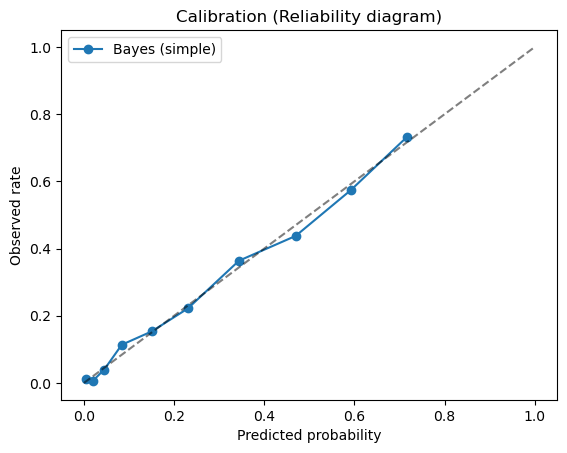

[warn] feature name length 22 != beta dim 6000. Using min length to align.
    feature  beta_mean   beta_lo   beta_hi    OR_mean     OR_lo     OR_hi  \
0        19  -0.156266 -2.343265  1.082734   1.325911  0.096014  2.952742   
1         4  -0.148033 -1.379286  0.844999   1.033465  0.214196  2.119364   
2        18  -0.139596 -1.828450  0.906838   4.470233  0.160662  2.476478   
3        16  -0.137991 -1.634670  0.875938   1.192394  0.195017  2.401126   
4         9  -0.133037 -2.736156  1.191796   5.428081  0.064819  3.292989   
5         8  -0.125917 -1.343299  2.103789   1.502926  0.004921  3.621253   
6        17  -0.122511 -1.290520  0.991696   1.115721  0.196947  2.458604   
7         0  -0.121303 -1.533654  1.114593   1.150878  0.215746  3.048326   
8        12  -0.119713 -1.570815  0.770881   1.121884  0.207876  2.161669   
9         7  -0.115948 -1.308997  1.466129   1.419084  0.003741  3.429306   
10       15  -0.113999 -1.576835  0.971342   1.144177  0.206628  2.641488   
1

/tmp/ipykernel_6374/199921067.py:51: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  beta_hdi  = np.asarray(az.hdi(beta_s, hdi_prob=hdi_prob))      # (K,2)
/tmp/ipykernel_6374/199921067.py:54: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  OR_hdi    = np.asarray(az.hdi(OR_s, hdi_prob=hdi_prob))


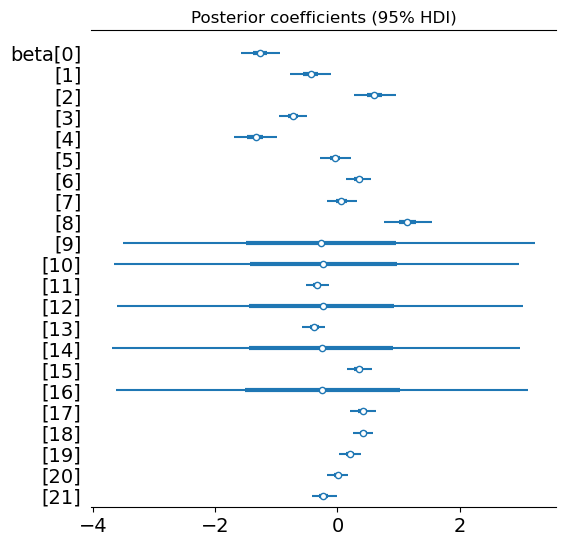

In [9]:
# HDI(highest density interval):
indiv_simple, (mean_pred, frac_pos) = summarize_individual_probs(p_s_blr, y_test, bins=10) 
print(indiv_simple.head(10))  # Q1: p_i mean & CI 

# LOO-PIT plot:
plot_calibration(mean_pred, frac_pos, label="Bayes (simple)") 

# rank beta factors and draw Forest plot:
feature_names = X_train.columns.tolist() 
imp_blr = rank_factors_beta_or(idata_blr, top_k=20)
print(imp_blr)
plot_forest_betas(idata_blr, var_names=["beta"], title="Posterior coefficients (95% HDI)")

In [10]:
# 4) Hierarchical Logistic (i.e., Contract, InternetService, PaymentMethod)
def make_index(series):
    cats = pd.Categorical(series) 
    return cats.codes, len(cats.categories)

grp_cols = [c for c in ["Contract","InternetService","PaymentMethod"] 
            if c in df.columns] 
G = {c: make_index(df.loc[X_train.index, c]) for c in grp_cols}

with pm.Model() as hlogit:
    alpha_global = pm.Normal("alpha_global", 0, 5)

    # A Random intercept per group: 
    a_contract   = pm.Normal("a_contract", 0, 1, shape=G["Contract"][1])    # 하이퍼는 더 계층화 가능
    a_internet   = pm.Normal("a_internet", 0, 1, shape=G["InternetService"][1])
    a_pay        = pm.Normal("a_pay", 0, 1, shape=G["PaymentMethod"][1])
    beta         = pm.Normal("beta", 0, 2, shape=n_features)

    # Group-offset per sample 
    offset = 0 
    if "Contract" in G:
        offset += a_contract[G["Contract"][0]]
    if "InternetService" in G:
        offset += a_internet[G["InternetService"][0]]
    if "PaymentMethod" in G:
        offset += a_pay[G["PaymentMethod"][0]]
    logits = alpha_global + offset + pm.math.dot(X_tr, beta)
    p = pm.Deterministic("p", pm.math.sigmoid(logits))
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y_tr)

    idata_h = pm.sample(
        1500, tune=1500, target_accept=0.9, 
        chains=4, random_seed=RANDOM_STATE,
        idata_kwargs={"log_likelihood": True})
    idata_h.extend(pm.sample_posterior_predictive(idata_h, extend_inferencedata=True))


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_global, a_contract, a_internet, a_pay, beta]


Output()

Sampling 4 chains for 1_500 tune and 1_500 draw iterations (6_000 + 6_000 draws total) took 540 seconds.
Sampling: [y_obs]


Output()

In [8]:

# =========================
# Hierarchical Logistic fit
# =========================
def _make_group_meta(series: pd.Series):
    cats = pd.Categorical(series)
    mapping = {cat: i for i, cat in enumerate(cats.categories)}
    codes = cats.codes.astype("int64")
    return {"map": mapping, "codes": codes, "cats": list(cats.categories)}

grp_cols = [c for c in ["Contract","InternetService","PaymentMethod"] if c in df.columns]
groups = {c: _make_group_meta(df.loc[X_train.index, c]) for c in grp_cols}

X_tr = X_train.to_numpy(dtype="float64")
y_tr = y_train.astype("int64")
n_features = X_tr.shape[1]

with pm.Model() as hlogit:
    alpha_global = pm.Normal("alpha_global", 0, 5)
    beta         = pm.Normal("beta", 0, 2, shape=n_features)

    # Random intercepts (이름을 명시적으로 고정)
    a_contract = pm.Normal("a_contract", 0, 1, shape=len(groups["Contract"]["cats"]))
    a_internet = pm.Normal("a_internet", 0, 1, shape=len(groups["InternetService"]["cats"]))
    a_pay      = pm.Normal("a_pay",      0, 1, shape=len(groups["PaymentMethod"]["cats"]))

    # 학습 데이터의 그룹 오프셋 구성
    offset = 0.0
    if "Contract" in groups:
        offset = offset + a_contract[groups["Contract"]["codes"]]
    if "InternetService" in groups:
        offset = offset + a_internet[groups["InternetService"]["codes"]]
    if "PaymentMethod" in groups:
        offset = offset + a_pay[groups["PaymentMethod"]["codes"]]

    logits = alpha_global + offset + pm.math.dot(X_tr, beta)
    p = pm.Deterministic("p", pm.math.sigmoid(logits))
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y_tr)

    idata_h = pm.sample(
        1500, tune=1500, target_accept=0.9, chains=4,
        random_seed=RANDOM_STATE, idata_kwargs={"log_likelihood": True}
    )
    idata_h.extend(pm.sample_posterior_predictive(idata_h, extend_inferencedata=True))



Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_global, beta, a_contract, a_internet, a_pay]


Output()

Sampling 4 chains for 1_500 tune and 1_500 draw iterations (6_000 + 6_000 draws total) took 270 seconds.
Sampling: [y_obs]


Output()

In [16]:
# ===========================================
# Posterior probabilities on TRAIN (N,S 행렬)
# ===========================================
import arviz as az
import numpy as np
from scipy.special import expit
def posterior_predict_prob_simple(idata, X_new, feature_names_train):
    if hasattr(X_new, "reindex"):
        X = X_new.reindex(columns = feature_names_train).to_numpy(dtype=np.float64)
    else:
        X = np.asarray(X_new, dtype=np.float64) 
    
    post = az.extract(idata, var_names=["alpha", "beta"], combined=True) 
    a = post["alpha"]
    b = post["beta"] 
    if "sample" in a.dims and a.dims[0] != "sample":
        a = a.transpose("sample", ...)
    if "sample" in b.dims and b.dims[0] != "sample":
        b = b.transpose("sample", ...) 
    
    alpha_s = np.asarray(a.values, dtype=np.float64) 
    beta_s = np.asarray(b.values, dtype=np.float64) 

    if beta_s.shape[0] != alpha_s.shape[0] and beta_s.shape[1] == alpha_s.shape[0]:
        beta_s = beta_s.T 
    logits = X @ beta_s.T + alpha_s[None, :] 
    return expit(logits) 


def posterior_predict_prob_hier(idata, X_new, df_groups_new, groups_train_meta, feature_names_train):
    """ 
    Return: (N, S) - Churn rate matrix of Observation N x Posterior Sample S
    - X_new enforces the order of features and dtype 
    - Apply code -1 -> Offset 0 for a new level that has never seen in training. 
    """
    # 0) Feature order + dtype
    if hasattr(X_new, "reindex"):
        X_mat = X_new.reindex(columns=feature_names_train).to_numpy(dtype=np.float64) 
    else:
        X_mat = np.asarray(X_new, dtype=np.float64) 
    
    N, K = X_mat.shape 

    # 1) Fix sample axis at the front in posterior
    post = az.extract(idata, combined=True) 
    a_da = post["alpha_global"] 
    if "sample" in a_da.dims and a_da.dims[0] != "sample": 
        a_da = a_da.transpose("sample", ...) 
        alpha_s = np.asarray(a_da.values, dtype=np.float64) 
    alpha_s = np.asarray(a_da.values, dtype=np.float64) 
    S = alpha_s.shape[0] 

    b_da = post["beta"] 
    if "sample" in b_da.dims and b_da.dims[0] != "sample": 
        b_da = b_da.transpose("sample", ...) 
    beta_s = np.asarray(b_da.values, dtype=np.float64) 
    if beta_s.shape[0] != S and beta_s.shape[1] == S:
        beta_s = beta_s.T 
    assert beta_s.shape == (S, K), f"beta shape {beta_s.shape}, expected (S={S}, K={K})"

    # 2) Base logit: (N,K)@(K,S) + (1,S) 
    logits = X_mat @ beta_s.T 
    logits = logits + alpha_s[None, :] 

    # 3) Random intercept - Training mapping
    for gname, varname in [("Contract", "a_contract"), 
                           ("InternetService", "a_internet"),
                           ("PaymentMethod", "a_pay")]:
        if (gname not in groups_train_meta) or (gname not in df_groups_new.columns):
            continue 
        da = post[varname] 
        if "sample" in da.dims and da.dims[0] != "sample":
            da = da.transpose("sample", ...) 
        a_s = np.asarray(da.values, dtype=np.float64) 
        if a_s.shape[0] != S and a_s.shape[1] == S: 
            a_s = a_s.T 
        assert a_s.shape[0] == S, f"{varname} shape {a_s.shape}, S={S}" 

        mapping = groups_train_meta[gname]["map"] 
        codes = (df_groups_new[gname]
                .astype(str)
                .map(mapping)
                .fillna(-1)
                .astype(int).values #(N,)
        )
        valid = codes>=0 
        if np.any(valid):
            idx = np.where(valid)[0] 
            logits[idx, :] += a_s[:, codes[valid]].T  # add (n_valid, S) 
    return expit(logits)

In [17]:
# ============================================
# Test Segment reports:
# - LOOP for per-segment report on TEST (simple & hierarchical)
# ============================================
import os 
# -------- settings --------
segments = ["Contract", "InternetService", "PaymentMethod"]   # 필요시 수정
output_dir = "segment_reports_test"
top_n = 25                      # 세그먼트별 상위 위험 고객 N
lam_uncertainty = 0.25          # 불확실성 벌점 계수 (score = mean - lam*CI폭)

os.makedirs(output_dir, exist_ok=True)

# -------- helpers --------
def _safe_name(s: str) -> str:
    return "".join(ch if ch.isalnum() or ch in "-_." else "_" for ch in s)

def _plot_segment_means(seg_df: pd.DataFrame, title: str, savepath: str):
    """세그먼트 평균 p와 95% CI를 간단 포레스트 형태로 저장"""
    seg_df = seg_df.sort_values("mean", ascending=True)
    y = np.arange(len(seg_df))
    plt.figure(figsize=(8, max(3, 0.35*len(seg_df))))
    plt.hlines(y, seg_df["lo5"], seg_df["hi95"], lw=2, alpha=0.9)
    plt.plot(seg_df["mean"], y, "o")
    plt.yticks(y, seg_df["segment"])
    plt.xlabel("Mean churn probability")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(savepath, dpi=160)
    plt.close()

def _save_topn_by_segment(p_s: np.ndarray, df_rows: pd.DataFrame, seg_col: str, save_csv: str, N=25):
    """세그먼트 레벨별 상위 위험 고객 Top-N (평균 p 기준) CSV 저장"""
    p_mean = p_s.mean(axis=1)
    lo5    = np.quantile(p_s, 0.05, axis=1)
    hi95   = np.quantile(p_s, 0.95, axis=1)

    out_rows = []
    levels = df_rows[seg_col].astype(str).unique()
    for g in levels:
        mask = (df_rows[seg_col].astype(str) == g)
        idxs = np.where(mask)[0]
        if idxs.size == 0:
            continue
        order = idxs[np.argsort(-p_mean[idxs])][:N]
        tmp = pd.DataFrame({
            "index": df_rows.index[order],
            seg_col: df_rows.loc[df_rows.index[order], seg_col].astype(str).values,
            "p_mean": p_mean[order],
            "p_lo5":  lo5[order],
            "p_hi95": hi95[order],
        })
        tmp["segment_size"] = int(mask.sum())
        out_rows.append(tmp)

    if out_rows:
        pd.concat(out_rows, ignore_index=True).to_csv(save_csv, index=False)

def _plot_calibration_by_segment(p_mean: np.ndarray, y_true: np.ndarray,
                                 df_rows: pd.DataFrame, seg_col: str, savepath: str, bins=8):
    """Segment level-wise Calibration(reliability) diagram"""
    levels = df_rows[seg_col].astype(str).unique()
    plt.figure(figsize=(7.5, 6))
    for g in levels:
        m = (df_rows[seg_col].astype(str) == g)
        if m.sum() < max(50, 2*bins):  # 표본이 너무 작으면 스킵
            continue
        frac_pos, mean_pred = calibration_curve(y_true[m], p_mean[m], n_bins=bins, strategy="quantile")
        plt.plot(mean_pred, frac_pos, marker="o", label=str(g))
    plt.plot([0,1],[0,1], "k--", alpha=0.5)
    plt.xlabel("Predicted probability"); plt.ylabel("Observed rate")
    plt.title(f"Calibration by {seg_col}")
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.savefig(savepath, dpi=160); plt.close()

# ====== 준비 ======
feature_names_train = X_train.columns.tolist()
df_test  = df.loc[X_test.index].copy()
df_train = df.loc[X_train.index].copy()  # (hier indexing 확인용)

# =====================================================
# A) SIMPLE model — TEST per-segment summaries
# =====================================================
p_s_test_simple = posterior_predict_prob_simple(
    idata_blr, 
    X_test, 
    feature_names_train
)   # (N,S)
p_mean_simple = p_s_test_simple.mean(axis=1)

for seg in segments:
    if seg not in df_test.columns:
        continue

    seg_summary = segment_mean_intervals(p_s_test_simple, df_test[[seg]], seg)
    global_mean = p_mean_simple.mean()
    seg_scored  = retention_targeting_scores(seg_summary, global_mean, lam=lam_uncertainty)

    # CSV
    seg_summary.to_csv(os.path.join(output_dir, f"simple_test_seg_{_safe_name(seg)}_summary.csv"), index=False)
    seg_scored.to_csv(os.path.join(output_dir, f"simple_test_seg_{_safe_name(seg)}_scored.csv"), index=False)

    # Plots
    _plot_segment_means(
        seg_summary,
        title=f"[Simple|TEST] segment means (95% CI): {seg}",
        savepath=os.path.join(output_dir, f"simple_test_seg_{_safe_name(seg)}_means.png"),
    )
    _save_topn_by_segment(
        p_s=p_s_test_simple, df_rows=df_test[[seg]], seg_col=seg,
        save_csv=os.path.join(output_dir, f"simple_test_seg_{_safe_name(seg)}_top{top_n}.csv"), N=top_n
    )
    _plot_calibration_by_segment(
        p_mean=p_mean_simple, y_true=y_test, df_rows=df_test[[seg]],
        seg_col=seg, savepath=os.path.join(output_dir, f"simple_test_seg_{_safe_name(seg)}_calib.png")
    )

# =====================================================
# B) HIERARCHICAL model — TEST per-segment summaries
#     (훈련에서 본 그룹 레벨만 랜덤절편이 존재 → 새 레벨은 오프셋 0)
# =====================================================
p_s_test_hier = posterior_predict_prob_hier(
    idata_h, 
    X_test,
    df_test[[c for c in segments if c in df_test.columns]],
    groups,
    feature_names_train
)   # (N,S)
p_mean_hier = p_s_test_hier.mean(axis=1)

for seg in segments:
    if seg not in df_test.columns:
        continue

    seg_summary = segment_mean_intervals(p_s_test_hier, df_test[[seg]], seg)
    global_mean = p_mean_hier.mean()
    seg_scored  = retention_targeting_scores(seg_summary, global_mean, lam=lam_uncertainty)

    # CSV
    seg_summary.to_csv(os.path.join(output_dir, f"hier_test_seg_{_safe_name(seg)}_summary.csv"), index=False)
    seg_scored.to_csv(os.path.join(output_dir, f"hier_test_seg_{_safe_name(seg)}_scored.csv"), index=False)

    # Plots
    _plot_segment_means(
        seg_summary,
        title=f"[Hier|TEST] segment means (95% CI): {seg}",
        savepath=os.path.join(output_dir, f"hier_test_seg_{_safe_name(seg)}_means.png"),
    )
    _save_topn_by_segment(
        p_s=p_s_test_hier, df_rows=df_test[[seg]], seg_col=seg,
        save_csv=os.path.join(output_dir, f"hier_test_seg_{_safe_name(seg)}_top{top_n}.csv"), N=top_n
    )
    _plot_calibration_by_segment(
        p_mean=p_mean_hier, y_true=y_test, df_rows=df_test[[seg]],
        seg_col=seg, savepath=os.path.join(output_dir, f"hier_test_seg_{_safe_name(seg)}_calib.png")
    )

print(f"Done. Files saved under: {os.path.abspath(output_dir)}")


Done. Files saved under: /root/vscode/portfolio/portfolio_01/scr/segment_reports_test


In [ ]:
# 5) Model Comparison: LOO/WAIC -----------------------------------
loo_blr  = az.loo(idata_blr)
loo_h    = az.loo(idata_h)
waic_blr = az.waic(idata_blr)
waic_h   = az.waic(idata_h)
print(loo_blr, "\n", loo_h)
print(waic_blr, "\n", waic_h)

Computed from 6000 posterior samples and 5282 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2215.12    40.31
p_loo       19.23        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     5282  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%
 
 Computed from 6000 posterior samples and 5282 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2215.00    40.27
p_loo       19.10        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     5282  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

Computed from 6000 posterior samples and 5282 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -2215.10    40.31
p_waic       19.21        - 
 Computed from 6000 posterior samples and 5282 observations log-likelihood matrix.

          Estimate       SE
elpd_wai

In [ ]:
# bayes_playbook.py — Telco churn example with reusable utilities
# Requires: pymc>=4, arviz, numpy, pandas, scikit-learn, matplotlib

import warnings, time, functools
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
from scipy.special import expit as sigmoid

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, log_loss, brier_score_loss
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
import matplotlib.pyplot as plt

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ---------------------------
# 0) Utilities & Narration
# ---------------------------

def banner(msg):
    print("\n" + "="*len(msg))
    print(msg)
    print("="*len(msg))

def timed(fn):
    @functools.wraps(fn)
    def wrap(*args, **kwargs):
        t0 = time.time()
        out = fn(*args, **kwargs)
        print(f"[{fn.__name__}] elapsed: {time.time()-t0:.2f}s")
        return out
    return wrap

# ---------------------------
# 1) Data prep
# ---------------------------

def load_telco_churn(path="../data/churn.csv", target="Churn"):
    """
    Loads Telco churn dataset; assumes 'Churn' is 'Yes'/'No'.
    Converts target to 0/1.
    """
    df = pd.read_csv(path)
    df.columns = [c.strip() for c in df.columns]
    y = (df[target].astype(str).str.lower().str.startswith("y")).astype(int).values
    X = df.drop(columns=[target])
    # Simple cleanups: coerce numeric where possible
    for col in X.columns:
        if X[col].dtype == "object":
            # strip spaces
            X[col] = X[col].astype(str).str.strip()
        else:
            # keep numeric
            pass
    return X, y, df

def split_data(X, y, test_size=0.25, random_state=RANDOM_STATE):
    return train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)

def make_preprocessor(X, drop_first=True):
    """
    Column-wise preprocessing:
      - numeric: StandardScaler
      - categorical: one-hot (drop_first to avoid linear dependency)
    Returns a sklearn Pipeline that outputs a dense numpy array and the final feature names.
    """
    drop_cols = ['customerID'] 
    X_raw = X.drop(columns=drop_cols, errors='ignore')
    cardi = X_raw.nunique(dropna=False)
    low_card = cardi[cardi <= 10].index.tolist()
    num_cols = [c for c in X_raw.columns if np.issubdtype(X_raw[c].dtype, np.number)]
    cat_cols = [c for c in low_card if c not in num_cols]
    from sklearn.preprocessing import OneHotEncoder

    ohe = OneHotEncoder(handle_unknown="ignore", drop="first" if drop_first else None, sparse_output=False)
    coltf = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", ohe, cat_cols),
        ],
        remainder="drop"
    )
    pipe = Pipeline([("prep", coltf)])
    return pipe, num_cols, cat_cols

def get_feature_names(prep, num_cols, cat_cols):
    """
    Retrieve final expanded feature names for interpretability.
    """
    num_feats = list(num_cols)
    enc = prep.named_steps["prep"].named_transformers_["cat"]
    cat_expanded = list(enc.get_feature_names_out(cat_cols))
    return num_feats + cat_expanded

# ---------------------------
# 2) Frequentist baseline
# ---------------------------

@timed
def fit_frequentist_logit(X_train, y_train):
    clf = LogisticRegression(max_iter=2000, solver="lbfgs", n_jobs=None)
    clf.fit(X_train, y_train)
    return clf

def evaluate_predictions(y_true, p_hat, label="model"):
    return {
        "model": label,
        "AUC": roc_auc_score(y_true, p_hat),
        "LogLoss": log_loss(y_true, np.clip(p_hat, 1e-6, 1-1e-6)),
        "Brier": brier_score_loss(y_true, p_hat),
    }

def plot_calibration(y_true, p1, p2=None, label1="Bayes", label2="Freq", n_bins=10):
    plt.figure(figsize=(6,5))
    prob_true, prob_pred = calibration_curve(y_true, p1, n_bins=n_bins, strategy="uniform")
    plt.plot(prob_pred, prob_true, marker="o", label=label1)
    if p2 is not None:
        prob_true2, prob_pred2 = calibration_curve(y_true, p2, n_bins=n_bins, strategy="uniform")
        plt.plot(prob_pred2, prob_true2, marker="s", label=label2)
    plt.plot([0,1],[0,1],"--", alpha=0.6)
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title("Reliability (Calibration) Diagram")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# ---------------------------
# 3) Bayesian logistic (single-level)
# ---------------------------

def build_bayes_logit(X, y, prior_scale=1.0, student_t=False):
    """
    Bayesian logistic regression with configurable priors.
    prior_scale = 1.0 -> weakly informative Normal(0,1) or StudentT(3, 0, 1)
    """
    with pm.Model() as model:
        n_features = X.shape[1]
        if student_t:
            beta = pm.StudentT("beta", nu=3, mu=0.0, sigma=prior_scale, shape=n_features)
            alpha = pm.StudentT("alpha", nu=3, mu=0.0, sigma=prior_scale)
        else:
            beta = pm.Normal("beta", mu=0.0, sigma=prior_scale, shape=n_features)
            alpha = pm.Normal("alpha", mu=0.0, sigma=prior_scale)

        logits = alpha + pm.math.dot(X, beta)
        p = pm.Deterministic("p", pm.math.sigmoid(logits))
        y_obs = pm.Bernoulli("y_obs", p=p, observed=y)
    return model

@timed
def sample_model(model, draws=1000, tune=1000, target_accept=0.9, chains=4, random_seed=RANDOM_STATE):
    with model:
        idata = pm.sample(draws=draws, tune=tune, target_accept=target_accept,
                          chains=chains, random_seed=random_seed, progressbar=True)
    return idata

def bayes_predict_proba_from_idata(idata, X):
    """
    Predictive probabilities p(y=1|x) by drawing from posterior of alpha, beta.
    Returns mean across posterior draws.
    """
    post = idata.posterior
    alpha = post["alpha"].stack(sample=("chain","draw")).values  # (D,)
    beta  = post["beta"].stack(sample=("chain","draw")).values   # (D, F)
    logits_draws = alpha[:, None] + X @ beta.T                 # (N, D)
    p_draws = sigmoid(logits_draws)
    return p_draws.mean(axis=1), p_draws  # mean and full draws (for intervals)

def diagnostics(idata, var_names=["alpha","beta"]):
    # Normalize var_names to a list (ArviZ/xarray dislikes tuples here)
    if var_names is None:
        vn = None
    elif isinstance(var_names, str):
        vn = [var_names]
    else:
        vn = list(var_names)
    summ = az.summary(idata, var_names=vn, round_to=2)
    print("\nConvergence diagnostics (R-hat ≈ 1.00 good; ESS higher is better):")
    display(summ)
    return summ

# ---------------------------
# 4) Hierarchical logistic
# ---------------------------

def encode_group(series):
    cats = pd.Categorical(series)
    return cats.codes.astype("int32"), list(cats.categories)

def build_hier_logit(X, y, group_df, prior_scale=1.0, student_t=False):
    """
    Hierarchical random-intercept logistic with multiple grouping factors.
    group_df: DataFrame with columns of group labels (strings), same length as y.
    """
    grp_codes = {}
    grp_levels = {}
    for col in group_df.columns:
        codes, levels = encode_group(group_df[col])
        grp_codes[col] = codes
        grp_levels[col] = len(levels)

    with pm.Model() as model:
        n_features = X.shape[1]

        # Global effects
        if student_t:
            beta = pm.StudentT("beta", nu=3, mu=0.0, sigma=prior_scale, shape=n_features)
            alpha_global = pm.StudentT("alpha_global", nu=3, mu=0.0, sigma=prior_scale)
        else:
            beta = pm.Normal("beta", mu=0.0, sigma=prior_scale, shape=n_features)
            alpha_global = pm.Normal("alpha_global", mu=0.0, sigma=prior_scale)

        # Random intercepts per group
        logits = alpha_global + pm.math.dot(X, beta)

        for col, codes in grp_codes.items():
            sd = pm.HalfNormal(f"sd_{col}", sigma=prior_scale)
            offset = pm.Normal(f"z_{col}", mu=0.0, sigma=1.0, shape=grp_levels[col])
            alpha_grp = pm.Deterministic(f"alpha_{col}", offset * sd)
            logits = logits + alpha_grp[codes]

        p = pm.Deterministic("p", pm.math.sigmoid(logits))
        y_obs = pm.Bernoulli("y_obs", p=p, observed=y)

    return model

# ---------------------------
# 5) Model comparison & CV
# ---------------------------

def waic_loo_table(idatas, names):
    rows = []
    for nm, idata in zip(names, idatas):
        loo = az.loo(idata)
        waic = az.waic(idata)
        rows.append({
            "Model": nm,
            "LOO": loo.elpd_loo,
            "LOO_SE": loo.se,
            "WAIC": waic.elpd_waic,
            "WAIC_SE": waic.se
        })
    return pd.DataFrame(rows).sort_values("LOO", ascending=False).reset_index(drop=True)

def kfold_predictive_check(X, y, builder_fn, builder_kwargs=None, k=3):
    """
    Light-weight K-fold predictive check for Bayesian model: returns avg AUC, LogLoss.
    (Keeps draws small for speed.)
    """
    if builder_kwargs is None: builder_kwargs = {}
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=RANDOM_STATE)
    aucs, logs = [], []
    for tr, te in skf.split(X, y):
        m = builder_fn(X[tr], y[tr], **builder_kwargs)
        idata = sample_model(m, draws=500, tune=500, target_accept=0.9, chains=2)
        p_mean, _ = bayes_predict_proba_from_idata(idata, X[te])
        aucs.append(roc_auc_score(y[te], p_mean))
        logs.append(log_loss(y[te], np.clip(p_mean, 1e-6, 1-1e-6)))
    return {"AUC_mean": np.mean(aucs), "AUC_std": np.std(aucs),
            "LogLoss_mean": np.mean(logs), "LogLoss_std": np.std(logs)}

# ---------------------------
# 6) Prior sensitivity sweep
# ---------------------------

def prior_sensitivity(X_train, y_train, X_val, y_val, configs):
    """
    configs: list of dicts, each with {"name": str, "student_t": bool, "prior_scale": float}
    Returns table of predictive metrics on validation set.
    """
    results = []
    for cfg in configs:
        name = cfg["name"]
        student_t = cfg.get("student_t", False)
        scale = cfg.get("prior_scale", 1.0)
        model = build_bayes_logit(X_train, y_train, prior_scale=scale, student_t=student_t)
        idata = sample_model(model, draws=1000, tune=1000, target_accept=0.9, chains=4)
        diagnostics(idata, var_names=("alpha","beta"))
        p_mean, _ = bayes_predict_proba_from_idata(idata, X_val)
        row = evaluate_predictions(y_val, p_mean, label=name)
        results.append(row)
    return pd.DataFrame(results).sort_values("LogLoss")




In [25]:
# ---------------------------
# 7) End-to-end run (Telco)
# ---------------------------

banner("Telco churn — End-to-end comparison with prior sensitivity and hierarchy")

# Load & split
X_raw, y, df = load_telco_churn(path="../data/churn.csv", target="Churn")

# Define some intuitive group columns for hierarchy if present:
group_cols = [c for c in ["Contract", "InternetService", "PaymentMethod"] if c in X_raw.columns]
group_df = X_raw[group_cols].copy() if group_cols else pd.DataFrame(index=X_raw.index)

# Train/valid/test split (train->val split from train)
X_tr, X_te, y_tr, y_te = split_data(X_raw, y, test_size=0.25, random_state=RANDOM_STATE)
X_tri, X_va, y_tri, y_va = train_test_split(X_tr, y_tr, test_size=0.25, stratify=y_tr, random_state=RANDOM_STATE)

# Preprocess to matrix
prep, num_cols, cat_cols = make_preprocessor(X_tri)
X_trm = prep.fit_transform(X_tri)         # fit on train-inner
X_vam = prep.transform(X_va)
X_tem = prep.transform(X_te)
feature_names = get_feature_names(prep, num_cols, cat_cols)
print(f"Final feature dim: {X_trm.shape[1]}  (num={len(num_cols)}, cat_expanded={len(feature_names)-len(num_cols)})")




Telco churn — End-to-end comparison with prior sensitivity and hierarchy
Final feature dim: 3791  (num=3, cat_expanded=3788)


/root/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [15] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/root/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [15] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
# Frequentist baseline
banner("Frequentist logistic baseline")
freq = fit_frequentist_logit(X_trm, y_tri)
p_va_freq = freq.predict_proba(X_vam)[:,1]
p_te_freq = freq.predict_proba(X_tem)[:,1]
print("Validation:", evaluate_predictions(y_va, p_va_freq, "Freq"))
print("Test:", evaluate_predictions(y_te, p_te_freq, "Freq"))

# Bayesian single-level — prior sensitivity
banner("Bayesian (single-level) — Prior sensitivity")
configs = [
    {"name":"Normal(0,1)", "student_t":False, "prior_scale":1.0},
    {"name":"Normal(0,2)", "student_t":False, "prior_scale":2.0},
    {"name":"StudentT(ν=3, σ=1)", "student_t":True, "prior_scale":1.0},
]
sens_table = prior_sensitivity(X_trm, y_tri, X_vam, y_va, configs)
display(sens_table)

# Choose best by LogLoss (lower is better) and refit on (train-inner+val)
best_name = sens_table.iloc[0]["model"]
best_cfg = next(cfg for cfg in configs if cfg["name"] == best_name)
banner(f"Refit best Bayesian prior on train+val: {best_name}")
X_tr_full = np.vstack([X_trm, X_vam])
y_tr_full = np.concatenate([y_tri, y_va])
bayes_model = build_bayes_logit(X_tr_full, y_tr_full, prior_scale=best_cfg["prior_scale"], student_t=best_cfg["student_t"])
idata_blr = sample_model(bayes_model, draws=1500, tune=1500, target_accept=0.9, chains=4)
diagnostics(idata_blr)

p_te_bayes_mean, p_te_bayes_draws = bayes_predict_proba_from_idata(idata_blr, X_tem)
print("Test (Bayes best):", evaluate_predictions(y_te, p_te_bayes_mean, "Bayes-best"))

# Hierarchical model (if group columns exist)
if len(group_cols) > 0:
    banner(f"Hierarchical logistic: random intercepts for {group_cols}")
    # we need codes aligned to the preprocessed rows; here we reindex group_df to splits
    grp_tri = group_df.loc[X_tri.index]
    grp_va  = group_df.loc[X_va.index]
    grp_te  = group_df.loc[X_te.index]

    # Build & sample on train+val (we reuse X_tr_full)
    grp_tr_full = pd.concat([grp_tri, grp_va], axis=0)

    hier_model = build_hier_logit(X_tr_full, y_tr_full, grp_tr_full, prior_scale=1.0, student_t=False)
    idata_h = sample_model(hier_model, draws=1500, tune=1500, target_accept=0.9, chains=4)
    diagnostics(idata_h)

    # For predictions on test, rebuild codes for test inside a temp model context:
    # (We can simply compute posterior samples using the trained model:
    #   since the random intercept arrays are in idata_h.posterior['alpha_<col>'],
    #   we need to map test codes to the same categories as training.)
    # To keep it succinct here, we’ll rebuild the codes using training categories:
    # Extract levels from the trained model via dims:
    post = idata_h.posterior
    logits_te = 0.0
    alpha_global = post["alpha_global"].stack(draw=("chain","draw")).values  # (D,)
    beta = post["beta"].stack(draw=("chain","draw")).values                  # (D,F)
    logits_te = alpha_global[:, None] + X_tem @ beta.T                       # (N, D)

    for col in group_cols:
        # Map test categories to training index space:
        # Recover number of levels from posterior dims
        # (alpha_col dims: chain, draw, <levels>)
        alpha_col = post[f"alpha_{col}"].stack(draw=("chain","draw")).values  # (D, G)
        # Build mapping from training categories to index:
        # We'll reconstruct from train+val grp categories
        # Safer approach: encode using train categories order
        cats_train = pd.Categorical(grp_tr_full[col])
        mapping = {cat: i for i, cat in enumerate(cats_train.categories)}
        te_codes = pd.Categorical(grp_te[col], categories=cats_train.categories).codes
        te_codes = np.where(te_codes < 0, 0, te_codes)  # unseen -> 0 (conservative)
        logits_te += alpha_col[:, te_codes].T  # shape align: (N,D)

    p_te_hier = sigmoid(logits_te)
    p_te_hier_mean = p_te_hier.mean(axis=1)
    print("Test (Hier):", evaluate_predictions(y_te, p_te_hier_mean, "Hier"))

    # Model comparison (LOO/WAIC)
    banner("Model comparison (LOO/WAIC)")
    comp = waic_loo_table([idata_blr, idata_h], ["Bayes-simple", "Bayes-hier"])
    display(comp)
else:
    print("No group columns found; skipping hierarchical model.")
    comp = waic_loo_table([idata_blr], ["Bayes-simple"])
    display(comp)




Frequentist logistic baseline


Initializing NUTS using jitter+adapt_diag...


[fit_frequentist_logit] elapsed: 0.84s
Validation: {'model': 'Freq', 'AUC': 0.8545598731165742, 'LogLoss': 0.4061670566507115, 'Brier': 0.1316246315564258}
Test: {'model': 'Freq', 'AUC': 0.8460618767561698, 'LogLoss': 0.41614047726441744, 'Brier': 0.13621560768768795}

Bayesian (single-level) — Prior sensitivity


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


Output()

In [ ]:
# Calibration: Bayes vs Frequentist on Test
banner("Calibration: Bayes vs Frequentist (test)")
plot_calibration(y_te, p_te_bayes_mean, p_te_freq, label1="Bayes", label2="Freq", n_bins=10)

# Posterior predictive intervals for probabilities (uncertainty ribbons)
banner("Posterior predictive probability intervals (example 200 points)")
idx = np.random.choice(len(y_te), size=min(200, len(y_te)), replace=False)
p_draws_subset = p_te_bayes_draws[idx]  # (m, D)
p_mean = p_draws_subset.mean(axis=1)
hdi_low, hdi_high = az.hdi(p_draws_subset, hdi_prob=0.95, multimodal=False).T  # (m,2) -> transpose to (2,m)

plt.figure(figsize=(8,4))
order = np.argsort(p_mean)
plt.fill_between(np.arange(len(order)), hdi_low[order], hdi_high[order], alpha=0.2, label="95% HDI")
plt.plot(np.arange(len(order)), p_mean[order], lw=1.5, label="Posterior mean p")
plt.ylabel("p(y=1)")
plt.xlabel("Sorted examples")
plt.title("Posterior uncertainty over predicted probabilities")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Optional: K-fold predictive check for Bayes-simple (small draws for speed)
banner("K-fold predictive check (Bayes-simple, 3-fold, light draws)")
cv_stats = kfold_predictive_check(X_tem, y_te, builder_fn=lambda X_, y_, **k: build_bayes_logit(X_, y_, prior_scale=1.0, student_t=False), builder_kwargs={}, k=3)
print(cv_stats)

banner("Done.")